In [1]:
### connect to the database and import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
con = sqlite3.connect('atliq_db.sqlite3') #-->specify the path to your 
#downloaded database just like you read csv files

### check all tables in the database
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

### execute simple query in Python with your connection
query="""Select * from 
dim_customer
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head(10)

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC
5,70004070,Atliq e Store,E-Commerce,Direct,Japan,ROA,APAC
6,70005163,Atliq e Store,E-Commerce,Direct,Pakistan,ROA,APAC
7,70006157,Atliq Exclusive,Brick & Mortar,Direct,Philiphines,ROA,APAC
8,70006158,Atliq e Store,E-Commerce,Direct,Philiphines,ROA,APAC
9,70007198,Atliq Exclusive,Brick & Mortar,Direct,South Korea,ROA,APAC


In [2]:
#Test if libraries can be access
#con = sqlite3.connect('atliq_db.sqlite3')
#query = "SELECT * FROM dim_product"
#dim_product = pd.read_sql_query(query, con)
#dim_product.head(5)

In [3]:
#Read all the libraries and assign them to names
dim_customer = pd.read_sql_query(query, con)
dim_product = pd.read_sql_query(query, con)
fact_pre_discount = pd.read_sql_query(query, con)
fact_manufacturing_cost = pd.read_sql_query(query, con)
fact_gross_price = pd.read_sql_query(query, con)
fact_sales_monthly = pd.read_sql_query(query, con)

In [9]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

# SQL query to select all columns from the dim_product table
query = "SELECT * FROM dim_product"

# Execute the query and load the result into a DataFrame
dim_product_df = pd.read_sql_query(query, con)

# Display the DataFrame
display(dim_product_df.head(5))

# Close the database connection
con.close()

,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard


# Top sellers

We will gather the top sellers for the month and have them display 

In [10]:
con = sqlite3.connect('atliq_db.sqlite3')

# Load the datasets into DataFrames
dim_customer = pd.read_sql_query("SELECT * FROM dim_customer", con)
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_pre_discount = pd.read_sql_query("SELECT * FROM fact_pre_discount", con)
fact_manufacturing_cost = pd.read_sql_query("SELECT * FROM fact_manufacturing_cost", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)

# Close the database connection
con.close()

In [11]:
# Merge fact_sales_monthly with dim_product to get product names
merged_data = pd.merge(fact_sales_monthly, dim_product, how='left', left_on='product_code', right_on='product_code')

In [12]:
# Convert 'date' column to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [13]:
# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')

In [14]:
# Aggregate sales data
monthly_sales = merged_data.groupby(['month_year', 'product'])['sold_quantity'].sum().reset_index()

In [15]:
# Rank the products by sales within each month
monthly_sales['rank'] = monthly_sales.groupby('month_year')['sold_quantity'].rank(method='first', ascending=False)

In [28]:
# Select the top 3 products for each month
top3_monthly_sales = monthly_sales[monthly_sales['rank'] <= 3].sort_values(['month_year', 'rank'])

In [29]:
# Display the results
display(top3_monthly_sales.head(8))

,month_year,product,sold_quantity,rank
1,2017-09,AQ Mforce Gen X,6188.0,1.0
0,2017-09,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,5237.0,2.0
3,2017-10,AQ Mforce Gen X,8388.0,1.0
2,2017-10,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,6472.0,2.0
5,2017-11,AQ Mforce Gen X,11370.0,1.0
4,2017-11,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9642.0,2.0
7,2017-12,AQ Mforce Gen X,12043.0,1.0
6,2017-12,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9572.0,2.0


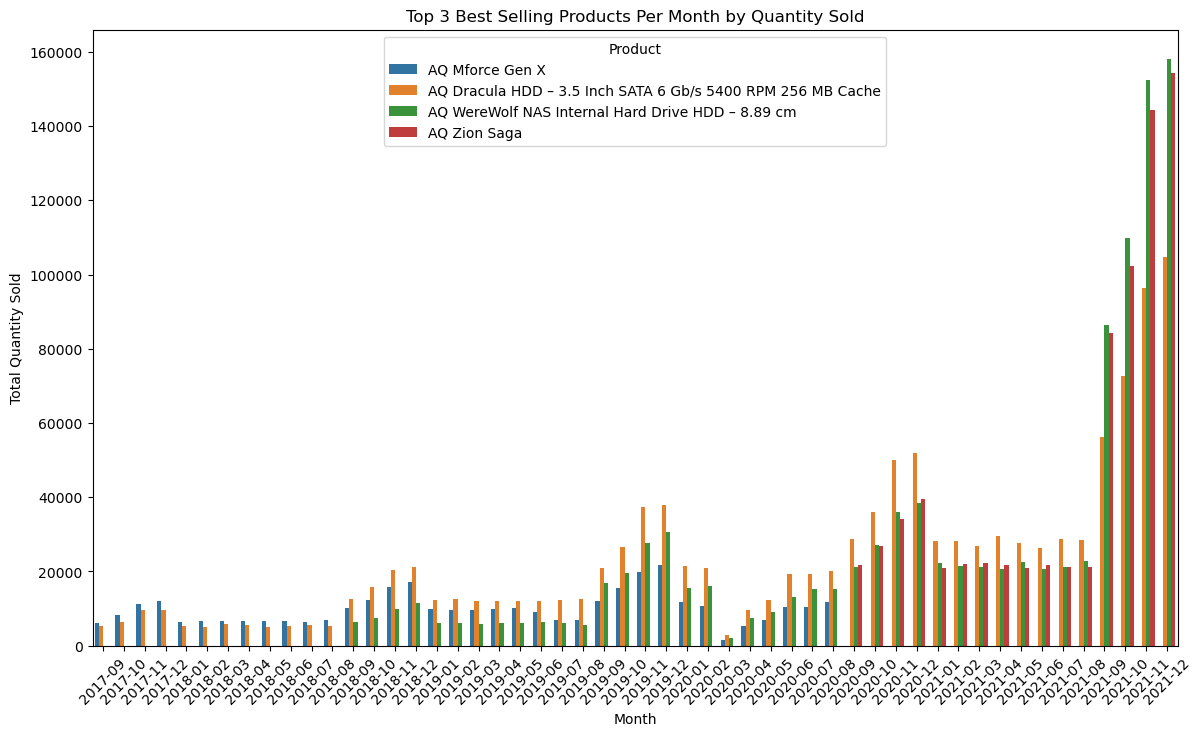

In [32]:
#Create a plot graph to show case how they are always the top sellers
plt.figure(figsize=(14, 8))
sns.barplot(x='month_year', y='sold_quantity', hue='product', data=top3_monthly_sales)
plt.title('Top 3 Best Selling Products Per Month by Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()